# LOAD IN PACKAGES AND DATA

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv(r"gemini_results.csv", delimiter=",", on_bad_lines="skip")

In [ ]:
df.head()

,original_id,original_input,label,cohere_resp,language,task
0,0,Augusto Santos Silva perguntou na Convenção Eu...,Em publicação partilhada viralmente nas redes ...,75,pt,cohere-zero-shot-100-threshold
1,2,"Isto nunca tinha sido feito na História, escre...",false,60,pt,cohere-zero-shot-100-threshold
2,4,SERÁ VERDADE. OLHA A SAFADEZA PRA DIZER QUE O ...,false,10,pt,cohere-zero-shot-100-threshold
3,3,Cortou a suntuosa verba do Carnaval e outros e...,false,40,pt,cohere-zero-shot-100-threshold
4,7,Nunca aconteceram incidentes graves [durante m...,partly true/misleading,40,pt,cohere-zero-shot-100-threshold


# PRE-PROCESSING?

In [ ]:
#remove unusable labels (long strings of text)
df = df[df['label'].isin(['true', 'mostly true', 'partly true/misleading', 'complicated/hard to categorise', 'other', 'mostly false', 'false'])]

df_numeric = df[pd.to_numeric(df['resp'], errors='coerce').notnull()]
#TODO can also mark non-numerics as wrong

In [ ]:
df_numeric.head()

,original_id,original_input,label,cohere_resp,language,task
1,2,"Isto nunca tinha sido feito na História, escre...",false,60,pt,cohere-zero-shot-100-threshold
2,4,SERÁ VERDADE. OLHA A SAFADEZA PRA DIZER QUE O ...,false,10,pt,cohere-zero-shot-100-threshold
3,3,Cortou a suntuosa verba do Carnaval e outros e...,false,40,pt,cohere-zero-shot-100-threshold
4,7,Nunca aconteceram incidentes graves [durante m...,partly true/misleading,40,pt,cohere-zero-shot-100-threshold
5,6,مقطع فيديو يوثق اعتداء شبان على الشرطة المصرية...,partly true/misleading,20,ar,cohere-zero-shot-100-threshold


# PRELIMINARY LOOK AT THE DATA

In [ ]:
df_numeric.shape

(3546, 6)

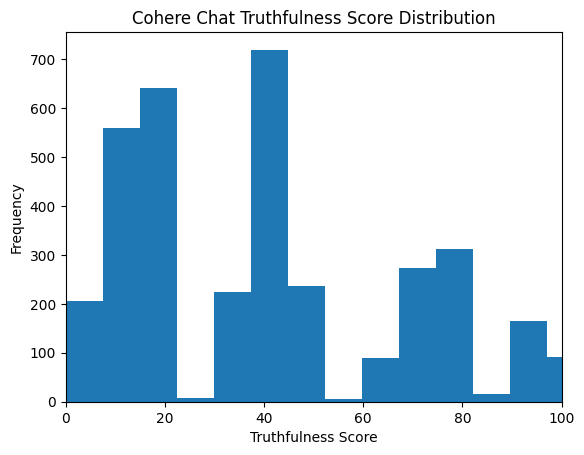

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df_numeric['resp'].map(float).values,bins=50)
plt.xlim(0,100)
plt.title("Cohere Chat Truthfulness Score Distribution")
plt.xlim(0,100)
plt.ylabel("Frequency")
plt.xlabel("Truthfulness Score")
plt.show()

In [ ]:
#label distribution
df_numeric["label"].value_counts()

In [ ]:
#language distribution
df_numeric["language"].value_counts()

language
pt    1019
id     435
ar     296
ka     271
pl     245
ta     208
es     190
it     184
hi     163
tr     157
de     132
ro     129
sr     117
Name: count, dtype: int64

# ACCURACY METRICS

In [ ]:
#this function is a helper to calculate accuracy according to the x-fact paper's next steps
def cohere_tv(row):
    resp = row['resp']
    try:
        resp = float(resp)
    except ValueError:
        return "unknown"
    
    if resp < 20: #TODO: tune this value?
        return "false"
    
    elif resp < 40:
        return "mostly false"
    
    elif resp < 60:
        return "partly true/misleading"
    
    elif resp < 80:
        return "mostly true"
    
    else:
        return "true"
    

df_numeric['resp_simple'] = df_numeric.apply(cohere_tv, axis=1)
# print(df_results0.shape)
df_processed = df_numeric.copy()#.drop(df_results0[(df_results0.cohere_simple != 0) & (df_results0.cohere_simple != 1)].index)
#df_processed = df_processed.drop(df_processed[df_processed.label.isin(['complicated/hard to categorise', 'other', np.nan])].index) #TODO: labels other than what's in the dict
df_processed = df_processed.reset_index()

In [ ]:
df_processed.head()

,index,original_id,original_input,label,cohere_resp,language,task,cohere_simple
0,1,2,"Isto nunca tinha sido feito na História, escre...",false,60,pt,cohere-zero-shot-100-threshold,mostly true
1,2,4,SERÁ VERDADE. OLHA A SAFADEZA PRA DIZER QUE O ...,false,10,pt,cohere-zero-shot-100-threshold,false
2,3,3,Cortou a suntuosa verba do Carnaval e outros e...,false,40,pt,cohere-zero-shot-100-threshold,partly true/misleading
3,4,7,Nunca aconteceram incidentes graves [durante m...,partly true/misleading,40,pt,cohere-zero-shot-100-threshold,partly true/misleading
4,5,6,مقطع فيديو يوثق اعتداء شبان على الشرطة المصرية...,partly true/misleading,20,ar,cohere-zero-shot-100-threshold,mostly false


### Overall Performance

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print(f1_score(df_processed['label'], df_processed['resp_simple'], average='macro'))
print(classification_report(df_processed['label'].values.tolist(), df_processed['resp_simple'].values.tolist()))

In [ ]:
def calculate_row_score(row): #according to concrete and x-fact code, available at https://github.com/khuangaf/CONCRETE/blob/master/src/xfact_eval.py
    score_mat = {

    'true':
            {
                'true':1.0,
                'mostly true':0.75,
                'partly true/misleading': 0.5,
                'complicated/hard to categorise': 0.0,
                'other': 0.0,
                'mostly false': 0.0,
                'false': 0.0
            },


    'mostly true':
            {
                'true':0.75,
                'mostly true':1.0,
                'partly true/misleading': 0.75,
                'complicated/hard to categorise': 0.0,
                'other': 0.0,
                'mostly false': 0.0,
                'false': 0.0
            },

    'partly true/misleading':
            {
                'true':0.25,
                'mostly true':0.50,
                'partly true/misleading': 1.0,
                'complicated/hard to categorise': 0.5,
                'other': 0.5,
                'mostly false': 0.50,
                'false': 0.25
            },



    'complicated/hard to categorise':
            {
                'true':0.0,
                'mostly true':0.0,
                'partly true/misleading': 0.0,
                'complicated/hard to categorise': 1.0,
                'other': 0.0,
                'mostly false': 0.0,
                'false': 0.0
            },


    'other':
            {
                'true':0.0,
                'mostly true':0.0,
                'partly true/misleading': 0,
                'complicated/hard to categorise': 0,
                'other': 1.0,
                'mostly false': 0.0,
                'false': 0.0
            },


    'mostly false':
            {
                'true':0.25,
                'mostly true':0.5,
                'partly true/misleading': 0.5,
                'complicated/hard to categorise': 0.5,
                'other': 0.5,
                'mostly false': 1.00,
                'false': 0.75
            },


    'false':
            {
                'true':0.0,
                'mostly true':0.25,
                'partly true/misleading': 0.5,
                'complicated/hard to categorise': 0.5,
                'other': 0.5,
                'mostly false': 0.75,
                'false': 1.0
            }


    }
    try:
        return score_mat[row["label"]][row["resp_simple"]]
    except KeyError: #shouldn't happen - TODO do some testing
        return 0
    
df_processed['score'] = df_processed.apply(calculate_row_score, axis=1)  


In [ ]:
df_processed.head()

,index,original_id,original_input,label,cohere_resp,language,task,cohere_simple,score
0,1,2,"Isto nunca tinha sido feito na História, escre...",false,60,pt,cohere-zero-shot-100-threshold,mostly true,0.25
1,2,4,SERÁ VERDADE. OLHA A SAFADEZA PRA DIZER QUE O ...,false,10,pt,cohere-zero-shot-100-threshold,false,1.00
2,3,3,Cortou a suntuosa verba do Carnaval e outros e...,false,40,pt,cohere-zero-shot-100-threshold,partly true/misleading,0.50
3,4,7,Nunca aconteceram incidentes graves [durante m...,partly true/misleading,40,pt,cohere-zero-shot-100-threshold,partly true/misleading,1.00
4,5,6,مقطع فيديو يوثق اعتداء شبان على الشرطة المصرية...,partly true/misleading,20,ar,cohere-zero-shot-100-threshold,mostly false,0.50


In [ ]:
print(df_processed["score"].sum() / len(df_processed["score"])) #note that concrete does this step inside the above function and produces a single score instead of a row-by-row score

0.5615482233502538
